In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#from fuzzywuzzy import process
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from tabulate import tabulate

In [2]:
df = pd.read_csv('EDA-Fase2.csv')
df.head()

,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,...,Structure_ls,Structure_b,Remarks_dealings including private road,Remarks_dealings in which auction or arbiter participates,Remarks_dealings of adjacent land,Remarks_dealings between related objects,Remarks_dealings including special circumstances,Remarks_dealings including valueless house,Remarks_dealings of real estate that includes wound etc.,Remarks_dealings of real estate to which mortgage etc. are set
0,1101,hokkaido,"chuo ward,sapporo city",minami8jonishi,nishi 18-chome,15.00000,15.00000,50000000,330,False,...,0,0,0,0,0,0,0,0,0,0
1,1102,hokkaido,"kita ward,sapporo city",tonden8jo,NaN,29.87038,29.87038,32000000,200,False,...,0,0,0,0,0,0,0,0,0,0
2,1107,hokkaido,"nishi ward,sapporo city",hachiken9jonishi,shinkawa (hokkaido),16.00000,16.00000,37000000,180,False,...,0,0,0,0,0,0,0,0,0,0
3,1108,hokkaido,"atsubetsu ward,sapporo city",atsubetsuhigashi5jo,shinrinkoen (hokkaido),5.00000,5.00000,35000000,190,False,...,0,0,0,0,0,0,0,0,0,0
4,4105,miyagi prefecture,"izumi ward,sendai city",fukuoka,izumichuo,120.00000,120.00000,380000,195,False,...,0,0,0,0,0,0,0,0,0,0


In [3]:
to_test=['MunicipalityCode',"Municipality", 'Prefecture', 'DistrictName', 'NearestStation']
to_delete = to_test
df[to_test]

,MunicipalityCode,Municipality,Prefecture,DistrictName,NearestStation
0,1101,"chuo ward,sapporo city",hokkaido,minami8jonishi,nishi 18-chome
1,1102,"kita ward,sapporo city",hokkaido,tonden8jo,NaN
2,1107,"nishi ward,sapporo city",hokkaido,hachiken9jonishi,shinkawa (hokkaido)
3,1108,"atsubetsu ward,sapporo city",hokkaido,atsubetsuhigashi5jo,shinrinkoen (hokkaido)
4,4105,"izumi ward,sendai city",miyagi prefecture,fukuoka,izumichuo
...,...,...,...,...,...
3887066,47362,"yaese town,shimajiri county",okinawa prefecture,aza kochinda,NaN
3887067,47362,"yaese town,shimajiri county",okinawa prefecture,aza tomoyose,NaN
3887068,47362,"yaese town,shimajiri county",okinawa prefecture,aza hokama,NaN
3887069,47362,"yaese town,shimajiri county",okinawa prefecture,aza yagibaru,NaN


In [4]:
for col in to_test:
    print(df[col].value_counts(dropna=False))

MunicipalityCode
13112    26167
13111    22489
13120    21972
13121    18381
13115    17734
         ...  
15586        9
7364         6
46304        6
47356        2
46303        2
Name: count, Length: 1893, dtype: int64
Municipality
setagaya ward                          26167
ota ward                               22489
nerima ward                            21972
adachi ward                            18381
suginami ward                          17734
                                       ...  
awashimaura village,iwafune county         9
hinoemata village,minamiaizu county        6
toshima village,kagoshima county           6
tonaki village,shimajiri county            2
mishima village,kagoshima county           2
Name: count, Length: 1879, dtype: int64
Prefecture
tokyo                   402959
kanagawa prefecture     278903
osaka prefecture        233517
saitama prefecture      208353
aichi prefecture        201604
hokkaido                185129
chiba prefecture        183766
hy

In [5]:
print("Data rows: ", df.shape[0])
for col in to_test:
    print(col)
    print("Null: ", df[col].isnull().sum())
    print("Amount categories: ", len(df[col].unique()))

Data rows:  3887071
MunicipalityCode
Null:  0
Amount categories:  1893
Municipality
Null:  0
Amount categories:  1879
Prefecture
Null:  0
Amount categories:  47
DistrictName
Null:  8180
Amount categories:  68669
NearestStation
Null:  557898
Amount categories:  8423


There is a large amount of categories,  an attempt to reduce them is performed in the following cells.

first, a searching of types is performed.

In [6]:
def look_for_similar_elements(dfi, column):
    results = {}
    
    unique_names = dfi[column].unique()
    names_list = list(unique_names)
    
    # Handle NaNs
    names_list = np.where(pd.isna(names_list), 'NO-' + column, names_list).tolist()
    
    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer(ngram_range=(1, 3)).fit_transform(names_list)
    vectors = vectorizer.toarray()
    
    # Calculate cosine similarity
    cosine_sim = cosine_similarity(vectors)
    
    for i in tqdm(range(len(names_list)), desc="Searching for similar names"):
        name = names_list[i]
        # Get indices of similarities above the threshold (e.g., 0.3)
        similar_indices = [j for j in range(i + 1, len(cosine_sim[i])) if cosine_sim[i][j] > 0.3 and i != j]
        
        # Save similar names in the dictionary
        similar_names = [names_list[j] for j in similar_indices] if similar_indices else ["NO SIMILAR"]
        
        results[name] = ", ".join(similar_names) if similar_names else '' 
    
    # Create the DataFrame ensuring each entry is a list
    df_similar = pd.DataFrame.from_dict(results, orient='index', columns=['similar'])
    
    # Remove entries without similar names
    df_similar = df_similar[~df_similar['similar'].str.contains("NO SIMILAR")]
    
    print("\nSimilar Names:")
    print(df_similar)

In [7]:
look_for_similar_elements(df.copy(), "NearestStation")

Searching for similar names: 100%|████████████████████████████████████████████████| 8423/8423 [00:14<00:00, 589.21it/s]



Similar Names:
                                                   similar
nishi 18-chome                              nango 18-chome
NO-NearestStation                                       no
shinkawa (hokkaido)     shinkawa (ehime), shinkawa (aichi)
shinrinkoen (hokkaido)               shinrinkoen (saitama)
omiya (saitama)                              omiya (kyoto)
...                                                    ...
kurosawa (jr)                         kurosawa (yurikogen)
chiyoricho 2-chome                      chiyoricho 1-chome
yamahana 19-jo                               yamahana 9-jo
shin-takaoka                              takaoka-yabunami
kenchomae (chiba)                       kenchomae (toyama)

[725 rows x 1 columns]


In [8]:
df_filtered = df[df['NearestStation'].str.contains('imazu (oita)', na=False,regex=False)]
df_filtered = df_filtered[[ 'MunicipalityCode', 'Prefecture', 'Municipality', 'DistrictName', 'NearestStation']]
print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+--------+--------------------+-----------------+----------------+----------------+------------------+
|        |   MunicipalityCode | Prefecture      | Municipality   | DistrictName   | NearestStation   |
|--------+--------------------+-----------------+----------------+----------------+------------------|
| 185530 |              44203 | oita prefecture | nakatsu city   | oaza idoda     | imazu (oita)     |
| 185594 |              44203 | oita prefecture | nakatsu city   | oaza morota    | imazu (oita)     |
| 248865 |              44203 | oita prefecture | nakatsu city   | oaza ueno      | imazu (oita)     |
| 248913 |              44203 | oita prefecture | nakatsu city   | oaza noyori    | imazu (oita)     |
| 249106 |              44211 | oita prefecture | usa city       | oaza tomiyama  | imazu (oita)     |
+--------+--------------------+-----------------+----------------+----------------+------------------+


There is data redundanci as some station contains info about the prefecture. they will be deleted

In [9]:
df['NearestStation'] = df['NearestStation'].str.replace(r'\s*\(.*?\)\s*', '', regex=True)

In [10]:
look_for_similar_elements(df.copy(), "NearestStation")

Searching for similar names: 100%|████████████████████████████████████████████████| 7951/7951 [00:12<00:00, 649.57it/s]



Similar Names:
                                   similar
nishi 18-chome              nango 18-chome
NO-NearestStation                       no
yotsuya                    yotsuya 3-chome
ginza                        ginza 1-chome
aoyama 1-chome                      aoyama
...                                    ...
sanbashidori 3-chome  sanbashidori 5-chome
chiyoricho 2-chome      chiyoricho 1-chome
yamahana 19-jo               yamahana 9-jo
nishikan-onmachi               kan-onmachi
shin-takaoka              takaoka-yabunami

[195 rows x 1 columns]


In [11]:
col = "NearestStation"
print(col)
print("Null: ", df[col].isnull().sum())
print("Amount categories: ", len(df[col].unique()))

NearestStation
Null:  557898
Amount categories:  7951


There are some statios that contains the name of the city in the name of the satation https://en.wikipedia.org/wiki/Shin-Yatsushiro_Station, but in this case is the actual name of the station, therefore it will no be deleted.

500 rows were deleted, but tere are 7951 still to 

In [12]:
#df_filtered = df.loc[df['Municipality'].str.lower() == 'awashimaura village, iwafune county']

df_filtered = df[df['Municipality'].str.contains('awashimaur', na=False,regex=False)]
df_filtered = df_filtered[to_test]
print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+--------+--------------------+------------------------------------+--------------------+----------------+------------------+
|        |   MunicipalityCode | Municipality                       | Prefecture         | DistrictName   |   NearestStation |
|--------+--------------------+------------------------------------+--------------------+----------------+------------------|
| 561223 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |              nan |
| 561224 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |              nan |
| 561225 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |              nan |
| 561226 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |              nan |
| 561227 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |            

In [13]:
df_filtered = df[df['Municipality'].str.contains('village', na=False,regex=False)]
df_filtered = df_filtered[to_test]
print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+-------+--------------------+--------------------------------------+-----------------+----------------+------------------+
|       |   MunicipalityCode | Municipality                         | Prefecture      | DistrictName   | NearestStation   |
|-------+--------------------+--------------------------------------+-----------------+----------------+------------------|
|  8217 |              21507 | higashishirakawa village,kamo county | gifu prefecture | goka           | shirakawaguchi   |
|  8218 |              21507 | higashishirakawa village,kamo county | gifu prefecture | goka           | shirakawaguchi   |
|  8228 |              21604 | shirakawa village,ono county         | gifu prefecture | oaza iijima    | hokuno           |
|  8229 |              21604 | shirakawa village,ono county         | gifu prefecture | oaza ushikubi  | nan              |
| 20253 |              21507 | higashishirakawa village,kamo county | gifu prefecture | otsubara       | shirakawaguchi   |
+-------

Municipality  seems  not correct as there is info about 2 locations, but looking on internet I found that for example shinshinotsu village,ishikari county, means that the actual municipality is shinshinotsu and country is ishikari 



In [14]:
#print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))
print(df['Municipality'].value_counts(dropna=False).to_string())

Municipality
setagaya ward                                  26167
ota ward                                       22489
nerima ward                                    21972
adachi ward                                    18381
suginami ward                                  17734
funabashi city                                 17436
kanazawa city                                  16477
kawaguchi city                                 16142
utsunomiya city                                15986
kagoshima city                                 15857
itabashi ward                                  15807
himeji city                                    15330
hachioji city                                  14959
gifu city                                      14694
toyama city                                    14429
koto ward                                      14345
edogawa ward                                   14229
matsuyama city                                 13986
shinjuku ward                    

city, ward, village, town and country

ward seems when it is not followed by city, it is tokio

changes are going to be made, new columns will be Municipality_ M, ward, city, country...

in this way, we extract the info about the type of municipality and type aspects

In [15]:
def extract_columns(row):
    tqdm.pandas()
    info = [item.strip() for item in row.split(',')]   
    name1 = info[0].split(' ')[0]
    kind = info[0].split(' ')[1]
    town = 0
    village  = 0
    ward = 0
    county = 0
    city = 0

    co_name = "no-name"
    ci_name = "no-name"
    
    if kind == "town":
        town = 1
    if kind == "village":
        village = 1
    if kind == "ward":
        ward = 1
    if kind == "county":
        county = 1
        co_name = name
    if kind == "city":
        city = 1
    
    info.pop(0)
    for data in info:
        name = data.split(' ')[0]
        kind = data.split(' ')[1]
        
        if kind == "town":
            town = 1
        if kind == "village":
            village = 1
        if kind == "ward":
            ward = 1
        if kind == "county":
            county = 1
            co_name = name
        if kind == "city":
            #city = 0
            ci_name = name
    
    return pd.Series([name1, village, town, ward , city, ci_name,county ,co_name])




In [16]:
data = {
    'City': [
        'yufu city',
        'shobara city',
        'tsumagoi village,agatsuma county',
        'kannami town,tagata county',
        'yahatahigashi ward, kitakyushu city',
        'komono town, mie county',
        'satte city'
    ]
}


df_test = pd.DataFrame(data)

df_test[['Municipality_M', 'Municipality_village', 'Municipality_towm', 
          'Municipality_ward', 'Municipality_city', 
          'Municipality_ci_name', 'Municipality_county', 
          'Municipality_co_name']] = df_test['City'].apply(lambda x: extract_columns(x))


print(df_test[['City','Municipality_M', 'Municipality_village', 'Municipality_towm', 
          'Municipality_ward', 'Municipality_city', 
          'Municipality_ci_name', 'Municipality_county', 
          'Municipality_co_name']])

                                  City Municipality_M  Municipality_village  \
0                            yufu city           yufu                     0   
1                         shobara city        shobara                     0   
2     tsumagoi village,agatsuma county       tsumagoi                     1   
3           kannami town,tagata county        kannami                     0   
4  yahatahigashi ward, kitakyushu city  yahatahigashi                     0   
5              komono town, mie county         komono                     0   
6                           satte city          satte                     0   

   Municipality_towm  Municipality_ward  Municipality_city  \
0                  0                  0                  1   
1                  0                  0                  1   
2                  0                  0                  0   
3                  1                  0                  0   
4                  0                  1                  

In [17]:
df[['Municipality_M', 'Municipality_village', 'Municipality_towm', 
          'Municipality_ward', 'Municipality_city', 
          'Municipality_ci_name', 'Municipality_county', 
          'Municipality_co_name']] = df['Municipality'].apply(lambda x: extract_columns(x))


print(df[['Municipality','Municipality_M', 'Municipality_village', 'Municipality_towm', 
          'Municipality_ward', 'Municipality_city', 
          'Municipality_ci_name', 'Municipality_county', 
          'Municipality_co_name']])

                        Municipality Municipality_M  Municipality_village  \
0             chuo ward,sapporo city           chuo                     0   
1             kita ward,sapporo city           kita                     0   
2            nishi ward,sapporo city          nishi                     0   
3        atsubetsu ward,sapporo city      atsubetsu                     0   
4             izumi ward,sendai city          izumi                     0   
...                              ...            ...                   ...   
3887066  yaese town,shimajiri county          yaese                     0   
3887067  yaese town,shimajiri county          yaese                     0   
3887068  yaese town,shimajiri county          yaese                     0   
3887069  yaese town,shimajiri county          yaese                     0   
3887070  yaese town,shimajiri county          yaese                     0   

         Municipality_towm  Municipality_ward  Municipality_city  \
0      

In [18]:
to_test = ['Municipality','Municipality_M', 'Municipality_village', 'Municipality_towm', 
          'Municipality_ward', 'Municipality_city', 
          'Municipality_ci_name', 'Municipality_county', 
          'Municipality_co_name']
print("Data rows: ", df.shape[0])
for col in to_test:
    print(col)
    print("Null: ", df[col].isnull().sum())
    print("Amount categories: ", len(df[col].unique()))

Data rows:  3887071
Municipality
Null:  0
Amount categories:  1879
Municipality_M
Null:  0
Amount categories:  1655
Municipality_village
Null:  0
Amount categories:  2
Municipality_towm
Null:  0
Amount categories:  2
Municipality_ward
Null:  0
Amount categories:  2
Municipality_city
Null:  0
Amount categories:  2
Municipality_ci_name
Null:  0
Amount categories:  21
Municipality_county
Null:  0
Amount categories:  2
Municipality_co_name
Null:  0
Amount categories:  357


In [19]:
for col in to_test:
    print(df[col].value_counts(dropna=False))

Municipality
setagaya ward                          26167
ota ward                               22489
nerima ward                            21972
adachi ward                            18381
suginami ward                          17734
                                       ...  
awashimaura village,iwafune county         9
hinoemata village,minamiaizu county        6
toshima village,kagoshima county           6
tonaki village,shimajiri county            2
mishima village,kagoshima county           2
Name: count, Length: 1879, dtype: int64
Municipality_M
chuo           69248
kita           65424
minami         62342
nishi          53543
higashi        38778
               ...  
tabayama          13
kosuge            10
awashimaura        9
hinoemata          6
tonaki             2
Name: count, Length: 1655, dtype: int64
Municipality_village
0    3854027
1      33044
Name: count, dtype: int64
Municipality_towm
0    3520796
1     366275
Name: count, dtype: int64
Municipality_ward
0    

In [20]:
def correlation_heatmap(dfi, target="TradePrice"):
    correlation_matrix = dfi.select_dtypes(include='number').corr()
    num_vars = correlation_matrix.shape[0]
    plt.figure(figsize=(num_vars * 2, num_vars * 1.5))
    
    heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    

    if target in correlation_matrix.columns:

        for i in range(correlation_matrix.shape[0]):
            if correlation_matrix.index[i] == target:
                heatmap.add_patch(plt.Rectangle((0, i), correlation_matrix.shape[1], 1, fill=False, edgecolor='yellow', lw=3))
            

            if abs(correlation_matrix.iloc[i][target]) > 0.2 and correlation_matrix.index[i] != target:
                heatmap.add_patch(plt.Rectangle((i, correlation_matrix.columns.get_loc(target)), 1, 1, fill=True, color='lightgreen', alpha=0.5))
    
    plt.title("Correlation Matrix")
    plt.show()

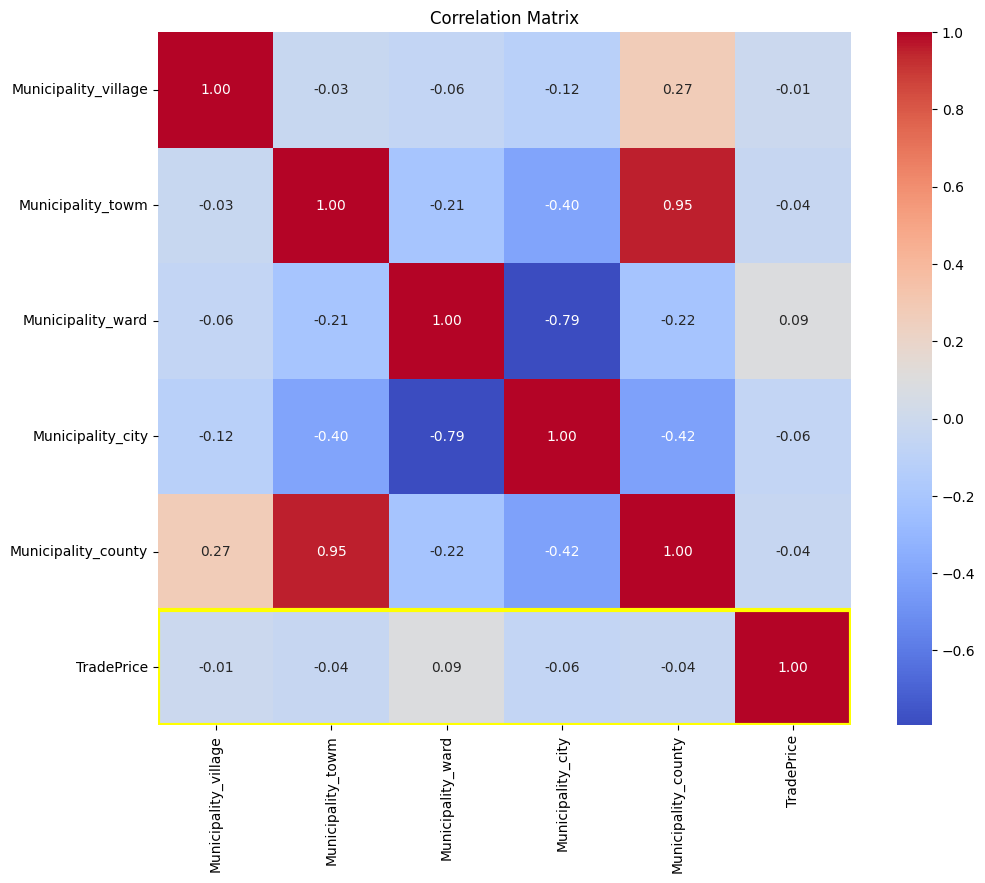

In [21]:

to_test.append("TradePrice")
#to_test.remove("TradePrice")
correlation_heatmap(df[to_test])

In [22]:
def check_kruskal_mannwhitneyu(dfi, categorical_columns, continuos_colum="TradePrice"):
    for var in categorical_columns:
        print(f'\nColumn Analysis: {var}')
        
        
        groups = dfi[var].unique()
        
        # Perfrom Mann-Whitney if there is 2 groups 
        if len(groups) == 2:
            group1 = dfi[dfi[var] == groups[0]][continuos_colum]
            group2 = dfi[dfi[var] == groups[1]][continuos_colum]
            
            u_stat, p_value_mannwhitney = stats.mannwhitneyu(group1, group2)
            print(f'Mann-Whitney U Test:')
            print(f'U-statistic: {u_stat}, P-value: {p_value_mannwhitney}')

        # Perfrom Kruskal-Wallis if there are more than 2 groups
        if len(groups) > 2:
            target_groups = []
    
            
            for group in groups:
                target = dfi[dfi[var] == group][continuos_colum]
                target_groups.append(target)
                
            h_stat, p_value_kruskal = stats.kruskal(*target_groups)
            print(f'Kruskal-Wallis H Test:')
            print(f'H-statistic: {h_stat}, P-value: {p_value_kruskal}')
 

In [23]:
to_test.remove("TradePrice")
to_test.remove("Municipality")

In [24]:
check_kruskal_mannwhitneyu(df.copy(),to_test)


Column Analysis: Municipality_M
Kruskal-Wallis H Test:
H-statistic: 1537668.3393354833, P-value: 0.0

Column Analysis: Municipality_village
Mann-Whitney U Test:
U-statistic: 98484255432.0, P-value: 0.0

Column Analysis: Municipality_towm
Mann-Whitney U Test:
U-statistic: 948804173826.5, P-value: 0.0

Column Analysis: Municipality_ward
Mann-Whitney U Test:
U-statistic: 2273782923065.0, P-value: 0.0

Column Analysis: Municipality_city
Mann-Whitney U Test:
U-statistic: 2182690345426.0, P-value: 0.0

Column Analysis: Municipality_ci_name
Kruskal-Wallis H Test:
H-statistic: 267869.99212236475, P-value: 0.0

Column Analysis: Municipality_county
Mann-Whitney U Test:
U-statistic: 1033089874467.0, P-value: 0.0

Column Analysis: Municipality_co_name
Kruskal-Wallis H Test:
H-statistic: 349537.71975048026, P-value: 0.0


The correlation matrix and kruskal and Mann test results that even though there is no strong linear correlation the data is relevant to the target as the p-values are small.

Due to the large number of categories, I just keep the information gathered in the last step.
The municipality and Municipality Code will be removed. 
Prefecture will be one-hot encoded.
DistrictName will be deleted
NearestStation will be modified and changed to a frequency.

In [25]:
frecuencias = df['NearestStation'].value_counts()

total_estaciones = len(df)

porcentajes = frecuencias / total_estaciones * 100

df['NearestStation_Freq'] = df['NearestStation'].map(porcentajes)

In [26]:
df[["TradePrice","NearestStation_Freq"]].corr()
#seems it is not good change

,TradePrice,NearestStation_Freq
TradePrice,1.000000,-0.003244
NearestStation_Freq,-0.003244,1.000000


In [27]:
def make_dummies_analyze(dfi, column_name, target="TradePrice"):
    dummies = pd.get_dummies(dfi[column_name], prefix=column_name, drop_first=False, dtype=int)
    #print("columns dummy", dummies.columns)
    dfi = pd.concat([dfi, dummies], axis=1)
    #print("columns dfi", dfi.columns)
    to_test = [col for col in dfi.columns if column_name in col]
    #print("columns created", to_test)
    to_test.insert(0,target)
    correlation_heatmap(dfi[to_test])
    to_test.remove(target)
    check_kruskal_mannwhitneyu(dfi,to_test)
    return dfi

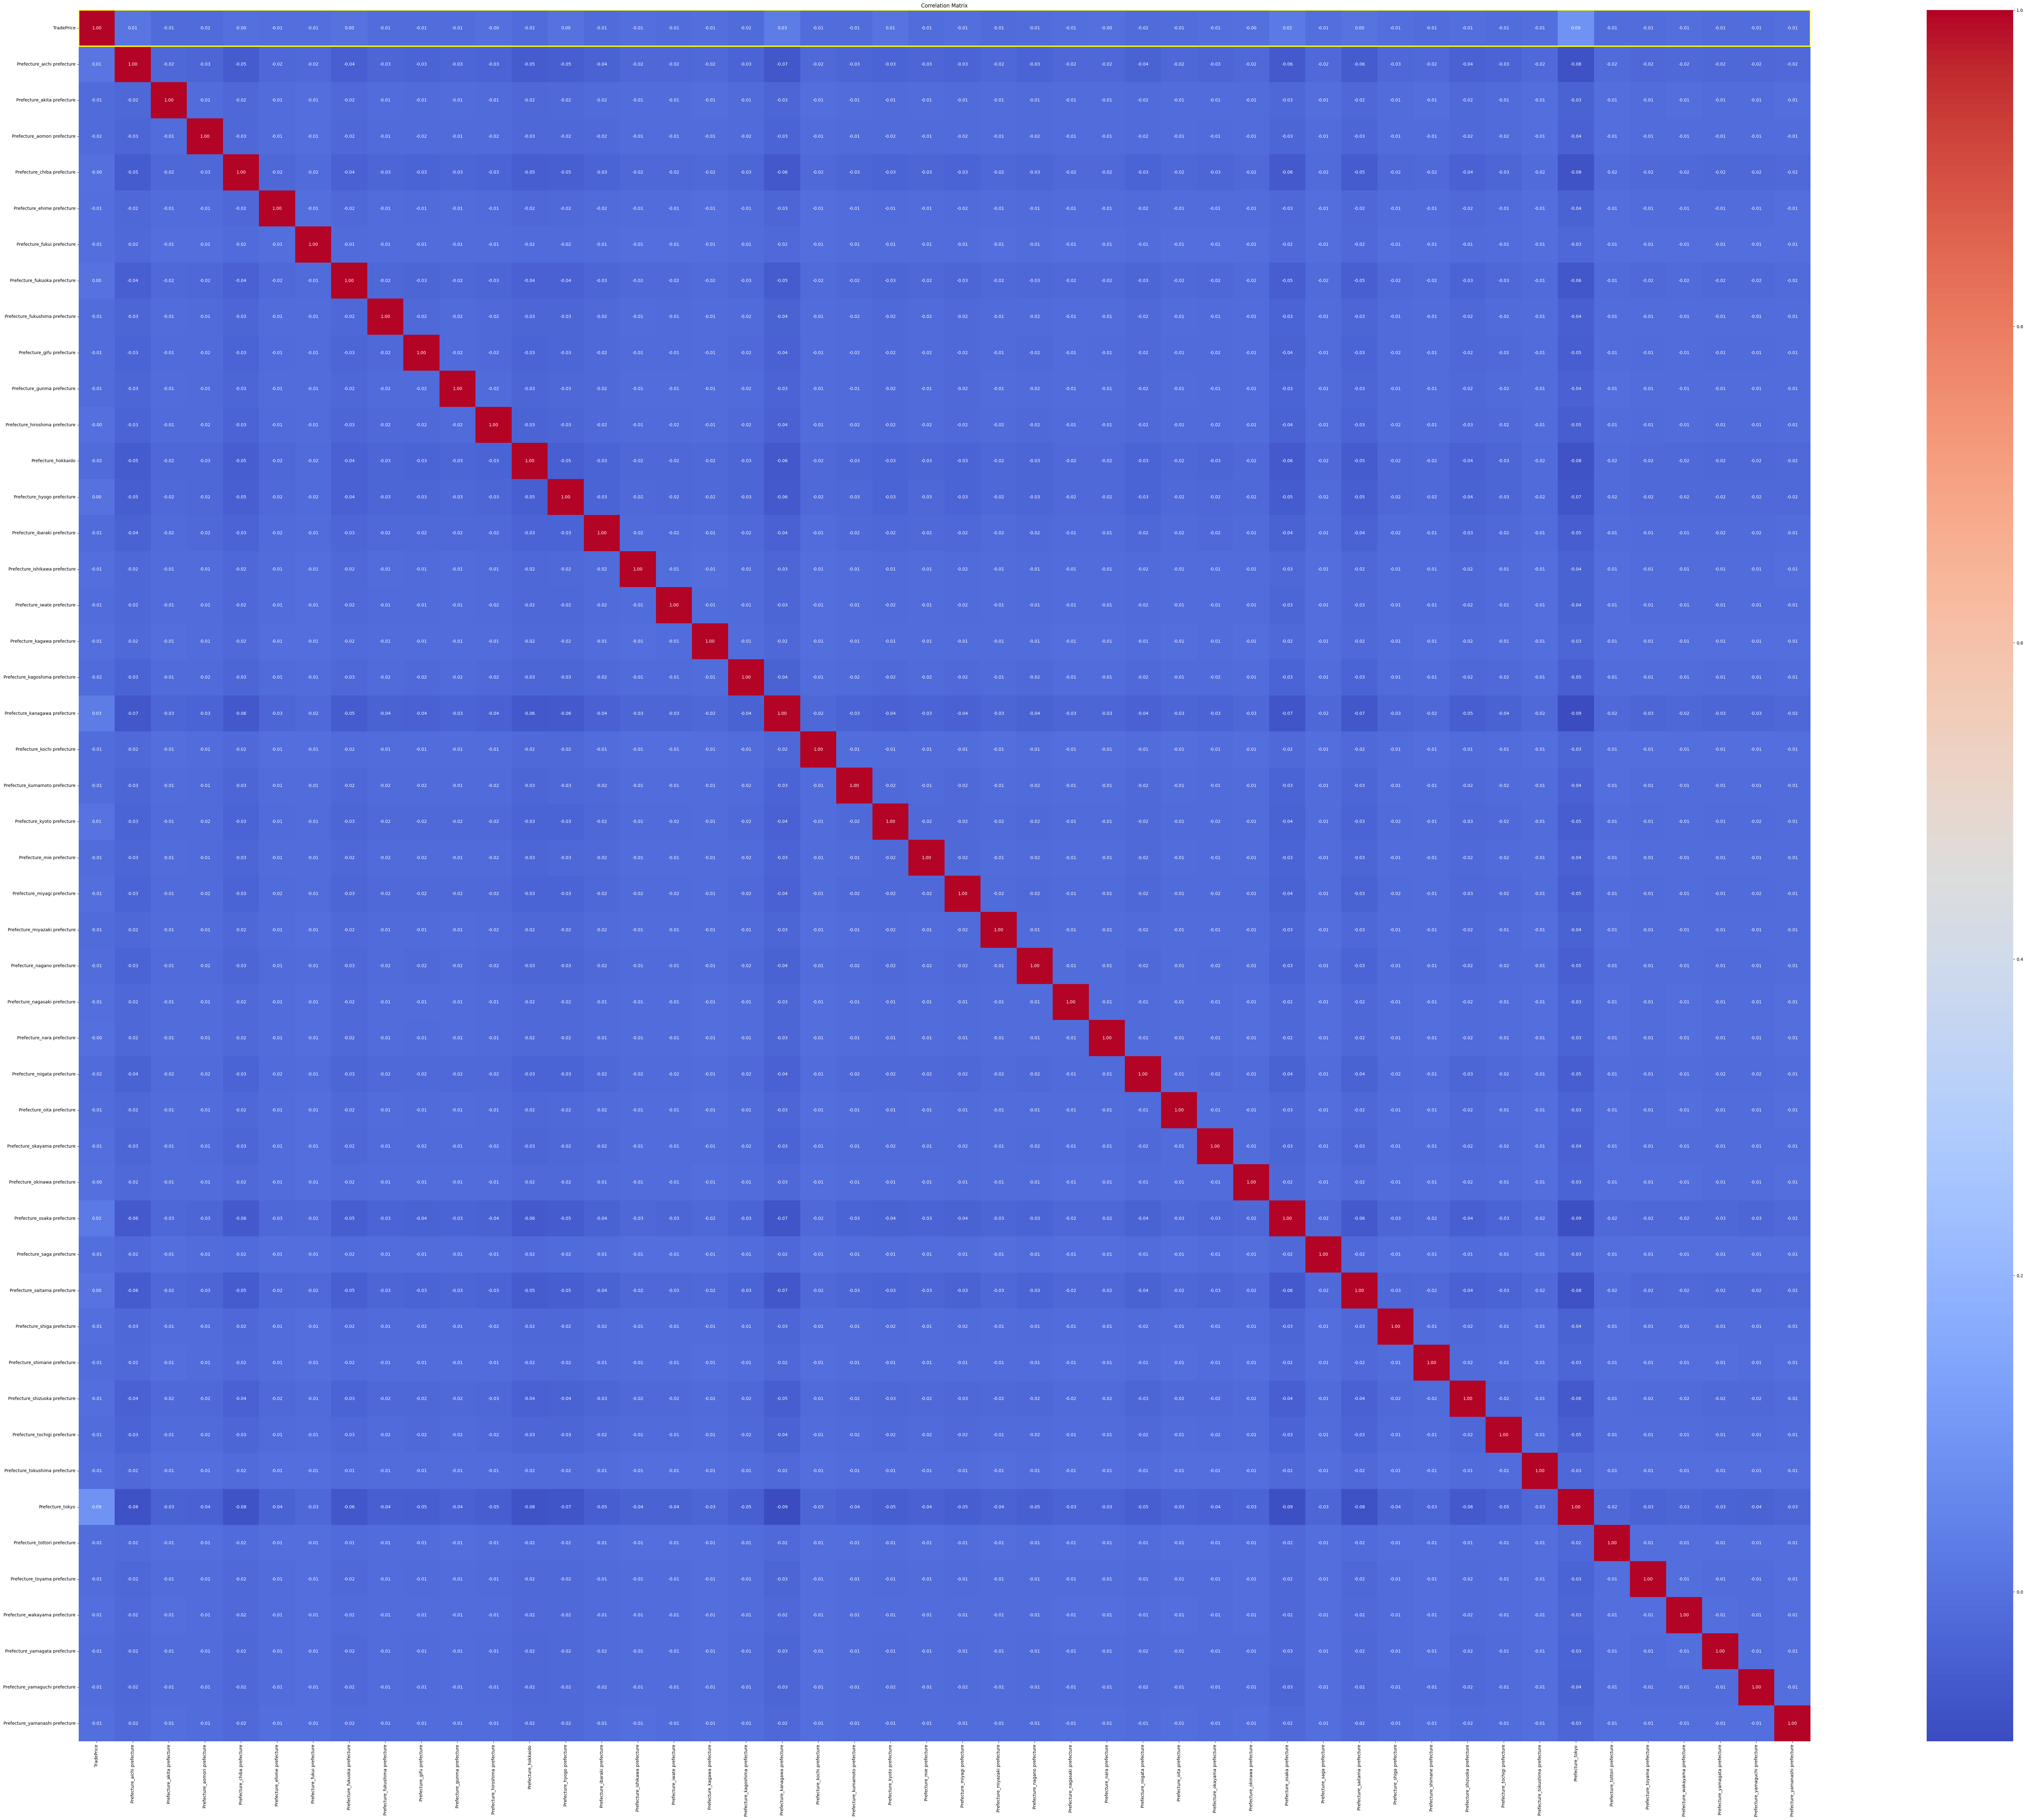


Column Analysis: Prefecture
Kruskal-Wallis H Test:
H-statistic: 1080038.553594745, P-value: 0.0

Column Analysis: Prefecture_aichi prefecture
Mann-Whitney U Test:
U-statistic: 278369356777.0, P-value: 0.0

Column Analysis: Prefecture_akita prefecture
Mann-Whitney U Test:
U-statistic: 116152164467.0, P-value: 0.0

Column Analysis: Prefecture_aomori prefecture
Mann-Whitney U Test:
U-statistic: 146899299759.0, P-value: 0.0

Column Analysis: Prefecture_chiba prefecture
Mann-Whitney U Test:
U-statistic: 318399605650.5, P-value: 0.0

Column Analysis: Prefecture_ehime prefecture
Mann-Whitney U Test:
U-statistic: 97053230439.0, P-value: 0.0

Column Analysis: Prefecture_fukui prefecture
Mann-Whitney U Test:
U-statistic: 54049984716.5, P-value: 0.0

Column Analysis: Prefecture_fukuoka prefecture
Mann-Whitney U Test:
U-statistic: 257932216812.0, P-value: 0.001117178420358526

Column Analysis: Prefecture_fukushima prefecture
Mann-Whitney U Test:
U-statistic: 155310930907.0, P-value: 0.0

Column A

In [28]:
df = make_dummies_analyze(df.copy(),"Prefecture")

The correlation matrix and kruskal and Mann test results that even though there is no strong linear correlation the data is relevant to the target as the p-values are small.

Big data engineering was performed in order to gather the information inside our data. Due to the large amount of categories, they were tyied to be reduced and kept the more generic data to avoid overfitting.
The following steps will be to find a model to predict the TradePrice.
Even though linear correlations were found, tree-based models are expected to perform better than linear ones. Anyway, many models will be tested on our data.

Kruskal-Wallis test was chosen (rather than ANOVA) due to the big dispersion of TradePrice and the large amount of outliers seen in the box plot. 

In [29]:
df.columns.to_list()

['MunicipalityCode',
 'Prefecture',
 'Municipality',
 'DistrictName',
 'NearestStation',
 'MinTimeToNearestStation',
 'MaxTimeToNearestStation',
 'TradePrice',
 'Area',
 'AreaIsGreaterFlag',
 'UnitPrice',
 'Frontage',
 'FrontageIsGreaterFlag',
 'TotalFloorArea',
 'TotalFloorAreaIsGreaterFlag',
 'BuildingYear',
 'PrewarBuilding',
 'Breadth',
 'CoverageRatio',
 'FloorAreaRatio',
 'Year',
 'Quarter',
 'Perfect_Price',
 'MaxBaseCoverage',
 'MaxTotalArea',
 'MaxPerfectPrice',
 'CoveragePerfectPrice',
 'Renovation_done',
 'Renovation_not yet',
 'Region_commercial area',
 'Region_industrial area',
 'Region_potential residential area',
 'Region_residential area',
 'Type_agricultural land',
 'Type_forest land',
 'Type_pre-owned condominiums, etc.',
 'Type_residential land(land and building)',
 'Type_residential land(land only)',
 'LandShape_flag-shaped etc.',
 'LandShape_irregular shaped',
 'LandShape_rectangular shaped',
 'LandShape_semi-rectangular shaped',
 'LandShape_semi-shaped',
 'LandSha

In [30]:
df = df.drop(columns=to_delete)

In [31]:
df.columns.to_list()

['MinTimeToNearestStation',
 'MaxTimeToNearestStation',
 'TradePrice',
 'Area',
 'AreaIsGreaterFlag',
 'UnitPrice',
 'Frontage',
 'FrontageIsGreaterFlag',
 'TotalFloorArea',
 'TotalFloorAreaIsGreaterFlag',
 'BuildingYear',
 'PrewarBuilding',
 'Breadth',
 'CoverageRatio',
 'FloorAreaRatio',
 'Year',
 'Quarter',
 'Perfect_Price',
 'MaxBaseCoverage',
 'MaxTotalArea',
 'MaxPerfectPrice',
 'CoveragePerfectPrice',
 'Renovation_done',
 'Renovation_not yet',
 'Region_commercial area',
 'Region_industrial area',
 'Region_potential residential area',
 'Region_residential area',
 'Type_agricultural land',
 'Type_forest land',
 'Type_pre-owned condominiums, etc.',
 'Type_residential land(land and building)',
 'Type_residential land(land only)',
 'LandShape_flag-shaped etc.',
 'LandShape_irregular shaped',
 'LandShape_rectangular shaped',
 'LandShape_semi-rectangular shaped',
 'LandShape_semi-shaped',
 'LandShape_semi-square shaped',
 'LandShape_semi-trapezoidal shaped',
 'LandShape_square shaped',

In [32]:
df.to_csv('EDA-Fase3.csv', index=False, header=True)